In [1]:
using Revise # Run this first, if you intend to develop the package

In [2]:
# unnecessary if you follow README
# using Pkg
# Pkg.activate("../QControl")
# Pkg.instantiate()

# Imports

In [3]:
using QControl

┌ Info: Precompiling QControl [edd81335-bcb3-4e33-9681-20bc820459a6]
└ @ Base loading.jl:1423


In [4]:
const QC = QControl;

In [23]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
using DifferentialEquations
const TO = TrajectoryOptimization
const RD = RobotDynamics
const DE = DifferentialEquations
;

In [25]:
methods(DE.ODEProblem)

# 3 methods for type constructor:
[1] ODEProblem(f::SciMLBase.AbstractODEFunction, u0, tspan, args...; kwargs...) in SciMLBase at /Users/phionx/.julia/packages/SciMLBase/OHiiA/src/problems/ode_problems.jl:71
[2] ODEProblem(f, u0, tspan) in SciMLBase at /Users/phionx/.julia/packages/SciMLBase/OHiiA/src/problems/ode_problems.jl:75
[3] ODEProblem(f, u0, tspan, p; kwargs...) in SciMLBase at /Users/phionx/.julia/packages/SciMLBase/OHiiA/src/problems/ode_problems.jl:75

# Single Qubit System

In [6]:
bq_single = SpinBasis(1//2)
H₀_single = 2*π*5*sigmaz(bq_single)/2
Hcs_single = [sigmax(bq_single)/2]
ψi_single = [spinup(bq_single)]
ψt_single = [spindown(bq_single)]
;

In [7]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, ψi_state, ψt_state = QC.gen_LQR_params(bq_single, H₀_single, Hcs_single, ψi_single, ψt_single)
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

In [8]:
model = QC.QuantumState();

In [9]:
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)

N = 1001 # number of time steps
tf = 3.0 # ns, total time
dt = tf / (N-1) # time step

# n_op = sigmap(bq_single)*sigmam(bq_single)
# Q = complex_to_real_isomorphism(n_op.data)
# Q = complex_to_real_isomorphism(one(bq_single).data)
Q = QC.complex_to_real_isomorphism([0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im])

# R = complex_to_real_isomorphism(reshape([1.0 + 0.0*im],(1,1)))
R = QC.complex_to_real_isomorphism(reshape([0.001 + 0.0*im],(1,1)))

I_matrix = QC.complex_to_real_isomorphism(one(bq_single).data .+ 0*im)
Qf = (I_matrix - ψt_state*transpose(QC.conj_isomorphism(ψt_state)))
# ⟨ψf|Qf|ψf⟩ = ⟨ψf|(I - |ψt⟩⟨ψt|)|ψf⟩ = 1 - |⟨ψf|ψt⟩|^2

obj = LQRObjective(Q,R,Qf,ψt_state,N);

In [10]:
# Add in normalization constraint and goal constraint
cons = ConstraintList(state_dim, control_dim, N)
normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), :state)
add_constraint!(cons, normcon, N)


# normcon = NormConstraint(state_dim, control_dim, π/3*2, Equality(), :control)
# add_constraint!(cons, normcon, N)

goalcon = GoalConstraint(ψt_state)
add_constraint!(cons, goalcon, N)

In [11]:
prob = Problem(model, obj, ψi_state, tf, xf=ψt_state, integration=RD.RK4(model), constraints=cons);

In [13]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [14]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=false);

In [15]:
solve!(solver);

┌ Warning: A not upper triangular. Creating a new upper-triangular matrix.
└ @ Altro.Cqdldl /Users/phionx/.julia/packages/Altro/jipqO/src/qdldl.jl:156


In [16]:
status(solver)

SOLVE_SUCCEEDED::TerminationStatus = 2

In [17]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 14
Final cost: 0.7643755388812399
Final constraint satisfaction: 3.9919996841497607e-7


In [18]:
X = states(solver)     # alternatively states(prob)
U = controls(solver)   # alternatively controls(prob)
Xv = Vector.(X)
Uv = Vector.(U)
Xcv = QC.real_to_complex_isomorphism.(Xv)
Ucv = QC.real_to_complex_isomorphism.(Uv)
Urv = map(cv -> real(cv)[1], Ucv)
Uiv = map(cv -> imag(cv)[1], Ucv)
Uav = map(cv -> norm(cv)[1], Ucv)
Xqv = map(cv -> normalize(Ket(bq_single, cv)), Xcv)
;

In [19]:
println(Xqv[1])
println(Xqv[end])

Ket(dim=2)
  basis: Spin(1/2)
      1.0 - 0.0im
 -1.0e-17 - 0.0im
Ket(dim=2)
  basis: Spin(1/2)
 -5.879043e-11 + 2.32308e-12im
           1.0 + 1.00893e-12im


In [20]:
szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);

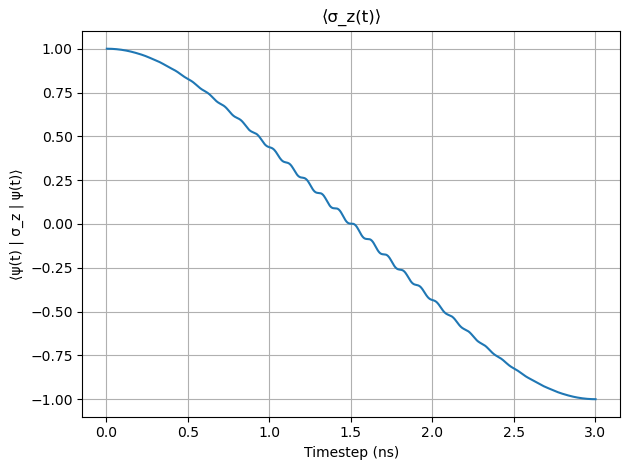

In [21]:
ts = 1:N
plot(dt*ts, szt)
xlabel("Timestep (ns)")
ylabel("⟨ψ(t) | σ_z | ψ(t)⟩")
title("⟨σ_z(t)⟩")
grid("on")
tight_layout()

# 3ns * 1.2 = pi

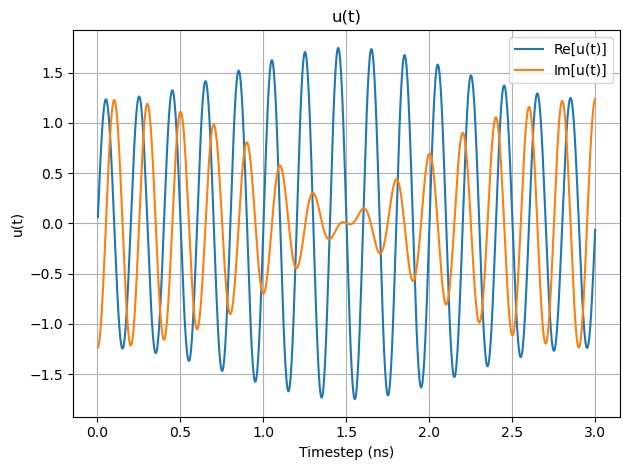

In [22]:
ts = 1:N-1
xlabel("Timestep (ns)")
ylabel("u(t)")
title("u(t)")
plot(dt*ts, Urv, label="Re[u(t)]")
plot(dt*ts, Uiv, label="Im[u(t)]")
# plot(dt*ts, Uav, label="|u(t)|")
grid("on")
legend()
tight_layout()

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)